In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용하는 디바이스:", device)

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("train.csv")
texts = df["재발방지대책 및 향후조치계획"].dropna().tolist()

# 2. 문장 임베딩 (Hugging Face의 ko-sBERT 모델 사용)
model_name = "jhgan/ko-sbert-sts"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)
model.eval()  # 평가 모드로 전환

def embed_text(text):
    # 입력 생성 후, 딕셔너리 내 모든 텐서를 GPU로 이동
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # outputs.last_hidden_state 또는 outputs[0] 사용 (모델에 따라 다름)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.squeeze().cpu().numpy()  # 결과는 CPU로 다시 이동

print("문장 임베딩 생성 중...")
embeddings = np.array([embed_text(text) for text in tqdm(texts)])

# 3. 클러스터링 (K-means 예시)
n_clusters = 5  # 군집 수는 도메인에 맞게 조정
print("클러스터링 진행 중...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)
df['cluster'] = clusters

# 4. 군집 해석: 각 클러스터별 대표 문장 추출 (유사도 기준 Top 5)
def get_top5_representative_texts(cluster_id):
    cluster_texts = df[df['cluster'] == cluster_id]["재발방지대책 및 향후조치계획"].tolist()
    cluster_embeddings = np.array([embed_text(t) for t in cluster_texts])
    centroid = cluster_embeddings.mean(axis=0)
    norms = np.linalg.norm(cluster_embeddings, axis=1) * np.linalg.norm(centroid)
    similarities = np.dot(cluster_embeddings, centroid) / (norms + 1e-8)
    top5_idx = similarities.argsort()[-5:][::-1]
    top5_texts = [cluster_texts[idx] for idx in top5_idx]
    return top5_texts

print("군집별 대표 문장(상위 5개) 추출 중...")
for i in tqdm(range(n_clusters)):
    top5_texts = get_top5_representative_texts(i)
    print(f"\nCluster {i} 대표 문장 Top 5:")
    for j, text in enumerate(top5_texts, 1):
        print(f"{j}. {text}")


  0%|          | 0/23422 [15:31<?, ?it/s]


UMAP 시각화 중...


c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50857 (\N{HANG

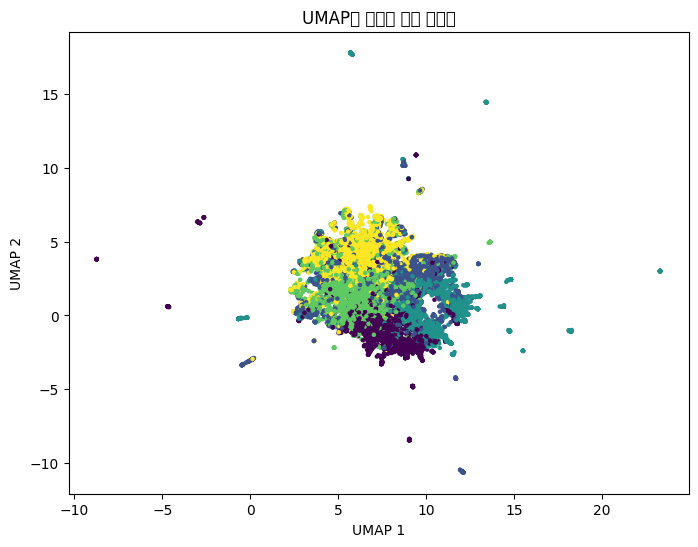

In [9]:
import umap.umap_ as umap

print("UMAP 시각화 중...")
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("UMAP을 활용한 군집 시각화")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [10]:
from sklearn.metrics import silhouette_score

# k 범위를 지정하여 최적의 k값을 찾는 예시
silhouette_scores = {}
for k in range(8, 21):  # k=2부터 10까지 테스트
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters_temp = kmeans_temp.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_temp)
    silhouette_scores[k] = score
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# 최적의 k값 선택 (silhouette score 최대)
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n최적의 k값: {optimal_k}")


k = 8, Silhouette Score = 0.0142
k = 9, Silhouette Score = 0.0170
k = 10, Silhouette Score = 0.0154
k = 11, Silhouette Score = 0.0199
k = 12, Silhouette Score = 0.0172
k = 13, Silhouette Score = 0.0171
k = 14, Silhouette Score = 0.0172
k = 15, Silhouette Score = 0.0171
k = 16, Silhouette Score = 0.0185
k = 17, Silhouette Score = 0.0186
k = 18, Silhouette Score = 0.0196
k = 19, Silhouette Score = 0.0202
k = 20, Silhouette Score = 0.0186

최적의 k값: 19


In [11]:
from sklearn.metrics import silhouette_score

# k 범위를 지정하여 최적의 k값을 찾는 예시
silhouette_scores = {}
for k in range(21, 50):  # k=2부터 10까지 테스트
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    clusters_temp = kmeans_temp.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_temp)
    silhouette_scores[k] = score
    print(f"k = {k}, Silhouette Score = {score:.4f}")

# 최적의 k값 선택 (silhouette score 최대)
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n최적의 k값: {optimal_k}")


k = 21, Silhouette Score = 0.0166
k = 22, Silhouette Score = 0.0178
k = 23, Silhouette Score = 0.0191
k = 24, Silhouette Score = 0.0202
k = 25, Silhouette Score = 0.0192
k = 26, Silhouette Score = 0.0198
k = 27, Silhouette Score = 0.0198
k = 28, Silhouette Score = 0.0188
k = 29, Silhouette Score = 0.0170
k = 30, Silhouette Score = 0.0170
k = 31, Silhouette Score = 0.0169
k = 32, Silhouette Score = 0.0179
k = 33, Silhouette Score = 0.0187
k = 34, Silhouette Score = 0.0155
k = 35, Silhouette Score = 0.0152
k = 36, Silhouette Score = 0.0157
k = 37, Silhouette Score = 0.0148
k = 38, Silhouette Score = 0.0135
k = 39, Silhouette Score = 0.0175
k = 40, Silhouette Score = 0.0177
k = 41, Silhouette Score = 0.0145
k = 42, Silhouette Score = 0.0143
k = 43, Silhouette Score = 0.0154
k = 44, Silhouette Score = 0.0171
k = 45, Silhouette Score = 0.0159
k = 46, Silhouette Score = 0.0158
k = 47, Silhouette Score = 0.0162
k = 48, Silhouette Score = 0.0163
k = 49, Silhouette Score = 0.0170

최적의 k값: 24


k=19일 때 시각화 진행 중...


c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL

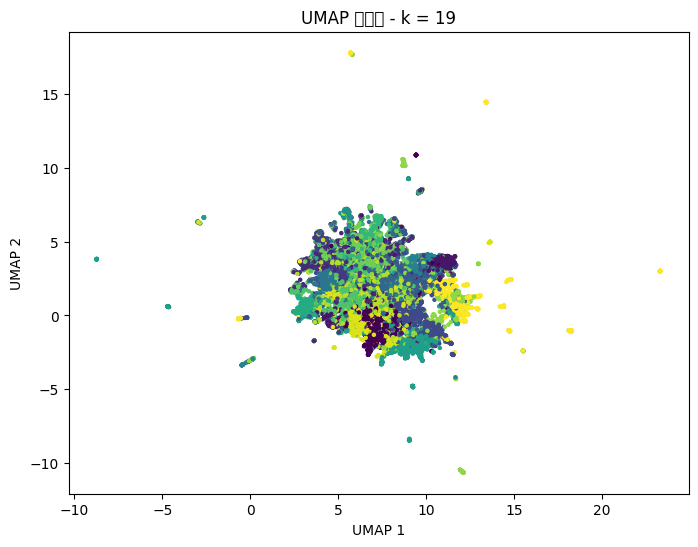

k=24일 때 시각화 진행 중...


c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minkyu\AppData\Local\anaconda3\envs\sd2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL

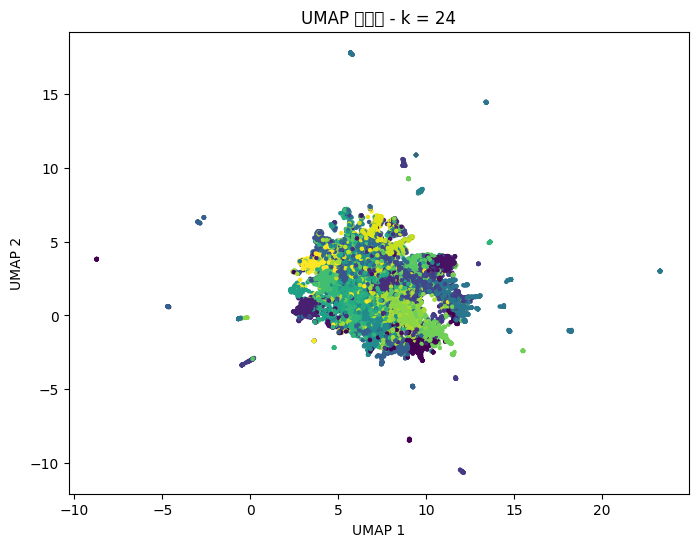

In [13]:
import umap.umap_ as umap

def visualize_clustering(embeddings, k):
    # k값에 따른 클러스터링 수행
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters_k = kmeans.fit_predict(embeddings)
    
    # UMAP을 이용하여 2차원으로 차원 축소
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)
    
    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters_k, cmap='viridis', s=5)
    plt.title(f"UMAP 시각화 - k = {k}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

print("k=19일 때 시각화 진행 중...")
visualize_clustering(embeddings, k=19)

print("k=24일 때 시각화 진행 중...")
visualize_clustering(embeddings, k=24)
